## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128], l2_ratio=1e-4):
    """Code Here
    建立你的神經網路
    """
    print(f"L2_RATIO:{l2_ratio}")
    input_layer = Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0 :
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(0.1)(x)
        else:
            x = BatchNormalization()(x)
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(0.1)(x)

    output = Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[output])
    model.summary()
    
    return model

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
EPOCHS = 50
MOMENTUM = 0.95
L2_RATIO =[1e-6, 1e-4, 1e-5]


In [10]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l2_ratio in L2_RATIO:
    model = build_mlp(x_train.shape[1:], l2_ratio=l2_ratio)
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train,
              epochs = EPOCHS,
              batch_size = BATCH_SIZE,
              validation_data = (x_test, y_test),
              shuffle = True, verbose = 0
              )
    
        # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    results[str(l2_ratio)] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}



L2_RAtIO:1e-06
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)    

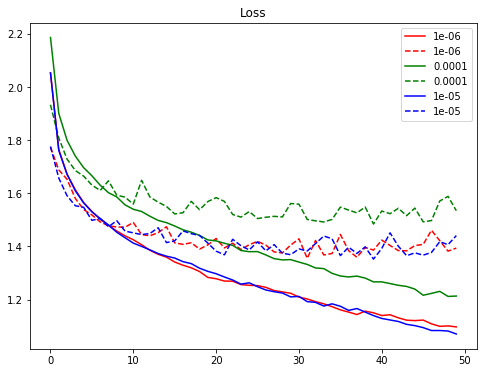

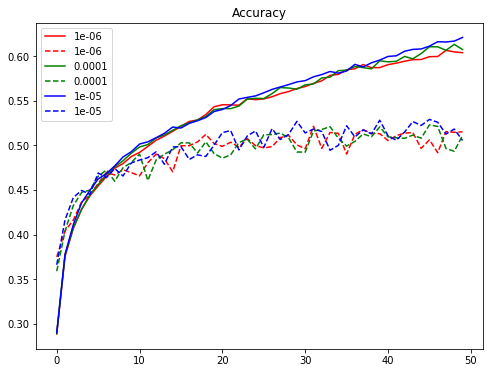

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
# plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()